In [120]:
import zipfile
z = zipfile.ZipFile("archive.zip")
z.extractall()

In [121]:
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [122]:
labels = ['PNEUMONIA','NORMAL']
img_size = 128
def get_data(data_dir):
    data = []
    for category in ["NORMAL", "PNEUMONIA"]:
        path = os.path.join(data_dir, category)
        class_num = 0 if category == "NORMAL" else 1
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                image = cv2.imread(img_path)
                # Ensure all images have the same dimensions
                image = cv2.resize(image, (128, 128))
                data.append([image, class_num])
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    # Convert to numpy array with proper formatting
    images = np.array([item[0] for item in data])
    labels = np.array([item[1] for item in data])
    return images, labels

In [123]:
import os
import cv2
import numpy as np

def load_dataset(dataset_path):
    image_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            # Skip .DS_Store files
            if file != '.DS_Store':
                image_files.append(os.path.join(root, file))
    return image_files

def get_data(dataset_path):
    images = []
    labels = []
    
    # Get normal images
    normal_path = os.path.join(dataset_path, "NORMAL")
    if os.path.exists(normal_path):
        for file in os.listdir(normal_path):
            # Skip .DS_Store files
            if file == '.DS_Store':
                continue
                
            file_path = os.path.join(normal_path, file)
            if os.path.isfile(file_path):
                try:
                    img = cv2.imread(file_path)
                    if img is not None:  # Make sure image was loaded successfully
                        # Resize or preprocess as needed
                        img = cv2.resize(img, (224, 224))  # Adjust size as needed
                        images.append(img)
                        labels.append(0)  # 0 for NORMAL
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    
    # Get pneumonia images
    pneumonia_path = os.path.join(dataset_path, "PNEUMONIA")
    if os.path.exists(pneumonia_path):
        for file in os.listdir(pneumonia_path):
            # Skip .DS_Store files
            if file == '.DS_Store':
                continue
                
            file_path = os.path.join(pneumonia_path, file)
            if os.path.isfile(file_path):
                try:
                    img = cv2.imread(file_path)
                    if img is not None:  # Make sure image was loaded successfully
                        # Resize or preprocess as needed
                        img = cv2.resize(img, (224, 224))  # Adjust size as needed
                        images.append(img)
                        labels.append(1)  # 1 for PNEUMONIA
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    
    return np.array(images), np.array(labels)

# Load datasets
train_images, train_labels = get_data("chest_xray/chest_xray/train")
test_images, test_labels = get_data("chest_xray/chest_xray/test")
val_images, val_labels = get_data("chest_xray/chest_xray/val")

In [124]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
penomina_dir = "chest_xray/train/PNEUMONIA"

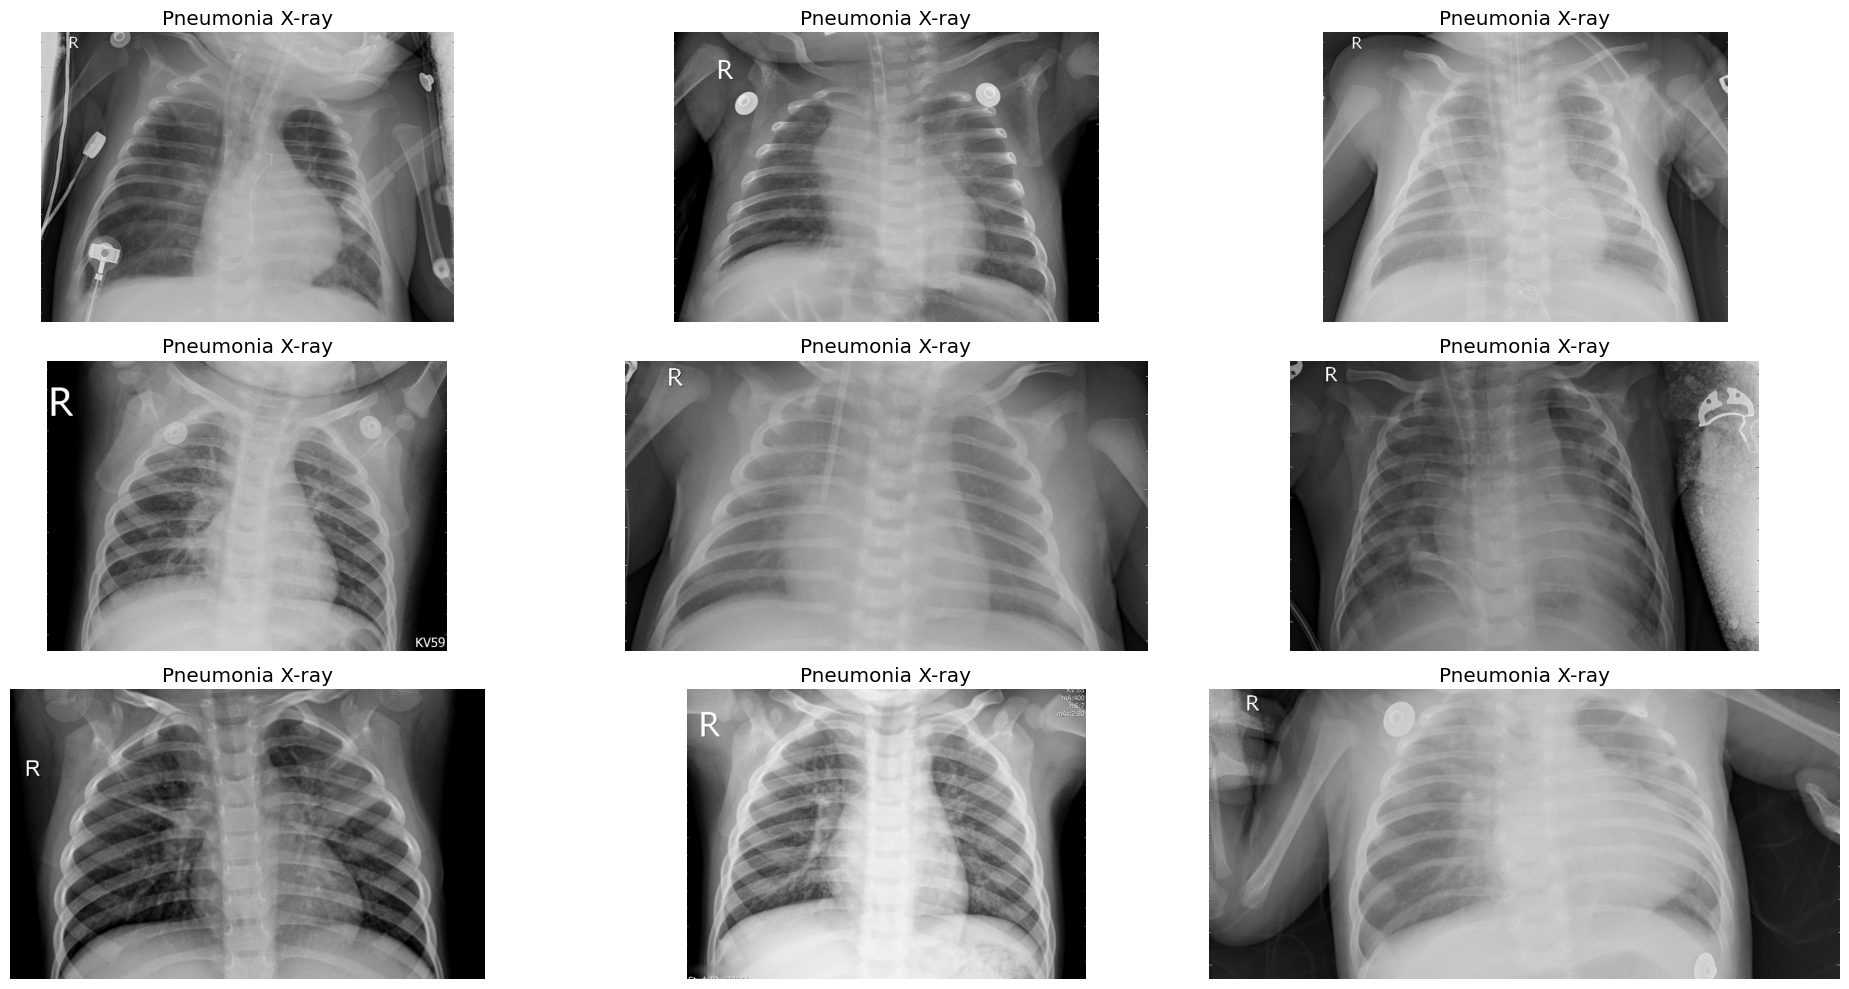

In [125]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(penomina_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [126]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

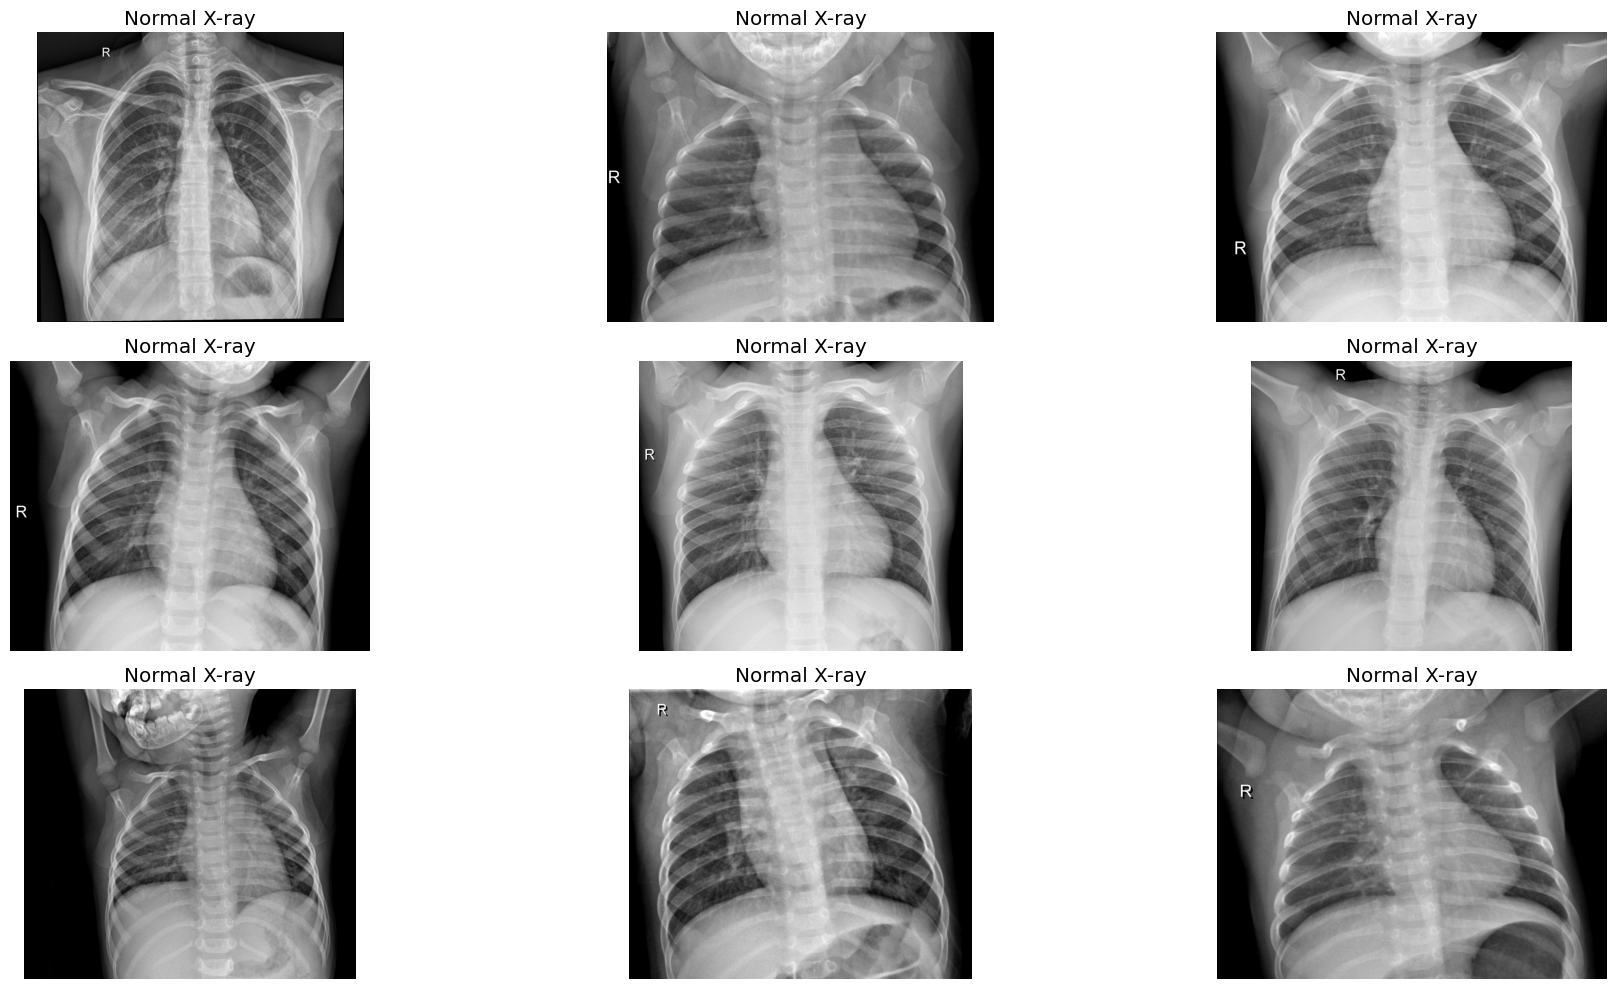

In [127]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

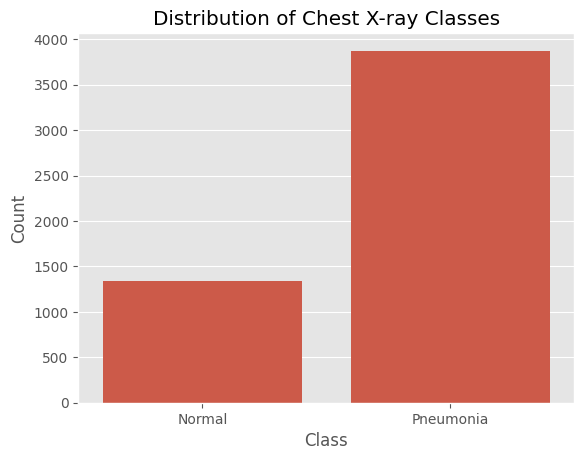

In [128]:
listx = []
for label in train_labels:
    if label == 0:
        listx.append("Normal")
    else:
        listx.append("Pneumonia")

sns.countplot(x=listx)
plt.title('Distribution of Chest X-ray Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [129]:
# Data Augmentation & Resizing

In [130]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [131]:
train_datagen = ImageDataGenerator(rescale = 1. / 255, 
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode="nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [132]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [133]:
class_labels = train_generator.class_indices

In [134]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [135]:
class_name = {value:key for (key, value) in class_labels.items()}

In [136]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [137]:
# VGG19 CNN Architecture

In [138]:
import requests
import os

# URL of the file
url = "https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
# Local path to save the file
target_path = os.path.expanduser("~/.keras/models/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(target_path), exist_ok=True)

# Download with verification disabled
response = requests.get(url, verify=False)
with open(target_path, 'wb') as f:
    f.write(response.content)

print(f"Downloaded to {target_path}")
base_model = VGG19(input_shape = (128,128,3),
                     include_top = False,
                     weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()

/Users/adityamath/Desktop/PNEUMONIA_DETECTION/.venv/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Downloaded to /Users/adityamath/.keras/models/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [139]:
filepath = "model.h5"
es = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
cp=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.01, nesterov=True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

/Users/adityamath/Desktop/PNEUMONIA_DETECTION/.venv/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [141]:
history_01 = model_01.fit(train_generator, 
            steps_per_epoch=50,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.6764 - loss: 0.6177

50/50 ━━━━━━━━━━━━━━━━━━━━ 46s 925ms/step - accuracy: 0.6770 - loss: 0.6176 - val_accuracy: 0.5000 - val_loss: 0.8053 - learning_rate: 1.0000e-04


In [142]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/vgg19_model_01.h5", overwrite=True)

In [143]:
test_generator = test_datagen.flow_from_directory("chest_xray/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [144]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.5000 - loss: 0.8053
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 819ms/step - accuracy: 0.6308 - loss: 0.6697


In [145]:
print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg_test_eval_01[1]}")

Validation Loss: 0.8052583932876587
Validation Accuarcy: 0.5
Test Loss: 0.6717701554298401
Test Accuarcy: 0.625


In [146]:
# Increamental unfreezing & fine tuning

In [147]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)


class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights("model_weights/vgg19_model_01.h5")

set_trainable = False
for layer in base_model.layers:
    if layer.name in [ 'block5_conv3','block5_conv4']:
        set_trainable=True
    if set_trainable:
        set_trainable=True
    else:
        set_trainable=False
print(model_02.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
base_model_layer_names

['input_3',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [148]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.01, nesterov=True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [149]:
# First, compile model_02
model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

# Then fit the model
history_02 = model_02.fit(train_generator,
                          steps_per_epoch=10,
                          epochs=1,
                          callbacks=[es, cp, lrr],
                          validation_data=valid_generator)

/Users/adityamath/Desktop/PNEUMONIA_DETECTION/.venv/lib/python3.11/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_179']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.7196 - loss: 0.6066 - val_accuracy: 0.5000 - val_loss: 0.8126 - learning_rate: 1.0000e-04


In [154]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg19_model_02.h5", overwrite=True)

In [155]:
model_02.load_weights("model_weights/vgg19_model_02.h5")

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg_val_eval_02[1]}")
print(f"Test Loss: {vgg_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg_test_eval_02[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step - accuracy: 0.5000 - loss: 0.8126
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 806ms/step - accuracy: 0.6230 - loss: 0.6741
Validation Loss: 0.8126412034034729
Validation Accuarcy: 0.5
Test Loss: 0.6732366681098938
Test Accuarcy: 0.625


In [38]:
# Unfreezing and fine tuning the entire network

In [158]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights("model_weights/vgg19_model_01.h5")

print(model_03.summary())

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [159]:
sgd = SGD(learning_rate=0.0001, decay=1e-6, momentum=0.01, nesterov=True)

model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [160]:
history_03 = model_02.fit(train_generator, 
            steps_per_epoch=100,
            epochs=1, 
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7503 - loss: 0.5710

100/100 ━━━━━━━━━━━━━━━━━━━━ 309s 3s/step - accuracy: 0.7502 - loss: 0.5710 - val_accuracy: 0.5000 - val_loss: 0.7654 - learning_rate: 1.0000e-04


In [161]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_02.save(filepath = "model_weights/vgg_unfrozen.h5", overwrite=True)